In [1]:
# 1 import package
import torch
import  torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.utils import save_image
from torchvision import transforms
import os
import matplotlib.pyplot as plt

/home/waj/anaconda3/envs/tts/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# 1 参数

In [3]:
BATCH_SIZE=512
EPOCHS=200
image_size=28
channel=1
z_dim=128
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )

# 2 加载数据

In [ ]:
def show_mnist_image(image_array, label):
    plt.imshow(image_array, cmap='Greys')
    plt.title(f"Label: {label}")
# 1 data loader 
dataset=datasets.MNIST("../data/",train=True,transform=transforms.Compose([
    transforms.Resize(28),transforms.ToTensor(),transforms.Normalize(0.5,0.5)
]))
mnist=DataLoader(dataset,shuffle=True,batch_size=BATCH_SIZE,drop_last=True)

In [ ]:
for data in mnist:
    print(data[0].shape)
    show_mnist_image(data[0][0][0], data[1][0])
    break

# 3 生成器

In [ ]:
# 2 genreator
class Generator( nn.Module):
    def __init__(self,z_dim):
        super(Generator,self).__init__()
        self.model=nn.Sequential(nn.Linear(z_dim,128),
                      nn.ReLU(),
                      nn.Linear(128,256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Linear(256,512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),
                      nn.Linear(512,1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024,image_size*image_size),          
                      nn.Tanh()
                     )
    def forward(self,z):
        x=self.model(z)
        return x

In [ ]:
data[0].shape

In [ ]:

g_x=torch.randn(BATCH_SIZE,z_dim).to(device)
g_model=Generator(z_dim).to(device)
g_model(g_x).shape

#  4 判别器

In [ ]:
# 3 diacriminator model
class Discriminator(nn.Module):
    def __init__(self,image_size):
        super(Discriminator,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(image_size**2,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        
        )
    def forward(self,x):
        x=self.model(x)
        return x.reshape(-1)

In [ ]:
d_model=Discriminator(28).to(device)
d_model(data[0].reshape(BATCH_SIZE,-1).to(device)).shape

In [ ]:
# 4 loss ,optimizer

In [ ]:
g_optim=torch.optim.Adam(g_model.parameters(),1e-4)
d_optim=torch.optim.Adam(d_model.parameters(),1e-4)

In [ ]:
loss_fn=nn.BCELoss()

# 5 模型训练

In [ ]:
index=0
for epoch in range(EPOCHS):
    for data,label in mnist:
        x=data.reshape(BATCH_SIZE,-1).to(device)
        # 5.1 生成器训练 generator
        z=torch.randn(BATCH_SIZE,z_dim).to(device)
        x_fake=g_model(z)
        ones=torch.ones(BATCH_SIZE).to(device)
        zeros=torch.zeros(BATCH_SIZE).to(device)
        g_optim.zero_grad()
        g_loss=loss_fn(d_model(x_fake),ones)
        g_loss.backward()
        g_optim.step()
        
        # 5.2 判别器训练
        # discriminator
        y_true=d_model(x)
        y_false=d_model(x_fake.detach())
        d_optim.zero_grad()
        d_loss=0.5*(loss_fn(y_true,ones)+loss_fn(y_false,zeros))
        d_loss.backward()
        d_optim.step()
        
        if index%100==0:
            print(f"epoch {epoch} ,step : {index} g_loss {g_loss} d_loss : {d_loss}")
            if index%100==0:
                os.makedirs("image",exist_ok=True)
                image=x_fake.reshape(BATCH_SIZE,1,28,28).data[:25]
                save_image(image,"image/%d.png" % index,normalize=True)
        index+=1

In [ ]:
# image generator

In [ ]:
# random z
z=torch.randn(25,z_dim).to(device)
g_x=g_model(z).reshape(-1,1,28,28).data # generator image

save_image(g_x,"image/test.png",normalize=True,nrow=5)

g_x=g_x.cpu().detach() # generator image
for i in range(5):
    show_mnist_image(g_x[i][0], "mnist")

In [ ]:
g_model(z).shape


# 保存模型

In [ ]:
# save  model
os.makedirs("model",exist_ok=True)
torch.save(g_model.state_dict(),"model/mnist_model.pth")

# 模型加载及使用

In [4]:

# 2 genreator
# 2 genreator
class Generator( nn.Module):
    def __init__(self,z_dim):
        super(Generator,self).__init__()
        self.model=nn.Sequential(nn.Linear(z_dim,128),
                      nn.ReLU(),
                      nn.Linear(128,256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Linear(256,512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),
                      nn.Linear(512,1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024,image_size*image_size),          
                      nn.Tanh()
                     )
    def forward(self,z):
        x=self.model(z)
        return x

# load and use model
g_new_model=Generator(z_dim).to(device)
g_new_model.load_state_dict(torch.load("model/mnist_model.pth"))

<All keys matched successfully>

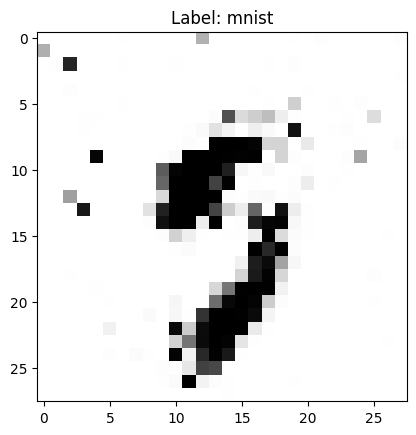

In [5]:
def show_mnist_image(image_array, label):
    plt.imshow(image_array, cmap='Greys')
    plt.title(f"Label: {label}")
    
z=torch.randn(25,z_dim).to(device)

g_x=g_new_model(z).reshape(-1,1,28,28).cpu().detach() # generator image

save_image(g_x,"image/test.png",normalize=True,nrow=5)
for i in range(5):
    show_mnist_image(g_x[i][0], "mnist")